Import statements

In [1]:
import os
import torch
import torchvision
from torch import nn 
from torch.autograd import Variable
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

Dataset download, splitting, and loading

In [2]:
batch_size = 256

# number of workers to use for parallelized data loading
num_workers = 0

# creates an instance of the torchvision.transforms.Compose() class, which
# allows one to create a transformation pipeline and do multiple transformations
# at once
transform = transforms.Compose([
    # converts the images to tensors
    transforms.ToTensor()
])

# Downloads the training portion of the MNIST dataset and stores it in ./data
initial_trainset = MNIST(
    root='./data',
    train=True,  # specifies the training portion of the MNIST dataset
    download=True,
    transform=transform  # transforms the image according to the transform defined earlier
)


testset = MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)



#splitting the training set into a trainset and validation set

train_proportion = 0.9

num_train = int(len(initial_trainset) * train_proportion)
num_val = len(initial_trainset) - num_train

trainset, valset = torch.utils.data.random_split(initial_trainset, [num_train, num_val]) #randomly splits initial_trainset into the actual trainset and validation set (valset)


# Creates a data loader for trainset
trainloader = DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True,  # shuffle the dataset before each epoch
    num_workers=num_workers
)


testloader = DataLoader(
    testset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers
)

valloader = DataLoader(
    valset, 
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers
)

100%|██████████| 9912422/9912422 [00:02<00:00, 4151020.81it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 18243327.38it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 2508995.81it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 2685821.06it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Setting up the model

In [3]:
#A new class inheriting from nn.Module
class Autoencoder(nn.Module):
    def __init__(self):
         super().__init__() #implcit super(Autoencoder, self)
         self.encoder = nn.Sequential( #encoder with two layers
            nn.Linear(784, 1600),
            nn.ReLU(),
            nn.Linear(1600, 1600),
            nn.ReLU(),
            nn.Linear(1600, 512),
            nn.ReLU(),
            nn.Linear(512, 36),
            nn.Sigmoid(),
            )
         self.decoder = nn.Sequential( 
            nn.Linear(36, 512),
            nn.ReLU(),
            nn.Linear(512, 1600),
            nn.ReLU(),
            nn.Linear(1600, 1600),
            nn.ReLU(),
            nn.Linear(1600, 784),
            nn.Sigmoid(),
            )
         
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

Model training & test set calculation

In [6]:
autoencoder = Autoencoder() #creates instance of Autoencoder class


criterion = nn.BCELoss() #BCELoss (Binary Cross Entropy loss) specifies the loss between two binary or near-binary inputs. Such as the white or black of these characters
optimizer = torch.optim.Adam(autoencoder.parameters()) #optimizer which takes as input all of the parameters of the model. Uses Adam (Adaptive Moment Estimation)

num_epochs = 10

#use the GPU to train if possible. Else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: " + ("GPU" if torch.cuda.is_available() else "CPU"))
autoencoder.to(device)



for epoch in range(num_epochs):

    train_running_loss = 0
    val_running_loss = 0

    #Use enumerate to tally the total number of batches for avg running loss calculations later on
    for train_batch_number, data in enumerate(trainloader, start = 1):
        img, _ = data #unpacks the data (which is in the form of a tuple), the first value of which are the images and the second is the label. We don't care about the label, so we use "_"
        img = img.view(img.size(0), -1) #the image is currently in the form a tensor of size (batch_size, 28, 28). We reshape (view) it so that it keeps the first dimension (batch_size) but the rest is squashed to 1 dimension. The -1 tells PyTorch to infer the dimension from the others, which turns out to be 28^2 = 784

        img = img.to(device) #ensure that img is on the same device as the model, as it will not run otherwise

        #forward
        output = autoencoder(img) #generate an output using the batch of images. Note that 'output' is more than just a simple tensor. It is an instance of torch.Tensor, and includes an attribute grad_fn, which references a Function object which created the tensor, allowing PyTorch to ultimately trace back the operatations which resulted in the tensor and perform backpropogation.
        loss = criterion(output, img) #calculate a loss between the output and original input. loss itself is an instance of the torch.Tensor class. It stores a tensor of 0 dimension (1 value), representing the loss

        train_running_loss += loss.item()

        #backward
        optimizer.zero_grad() #zeros out the gradient. To be more specific, each parameter of the model has a .grad attribute. This is zeroed out
        loss.backward() #Using a computational graph which stores all of the operations which occured to result in the loss value, loss then performs backpropogation on the model, setting the .grad attribute for each parameter as it does so
        optimizer.step() #the optimizer then updates each parameter based on its .grad attribute. The process of updating any one parameter is independant from those of the rest, so order doesn't really matter


    #calculate validation set running loss
    for val_batch_number, data in enumerate(valset, start = 1):

        img, _ = data
        img = img.view(img.size(0), -1)
        img = img.to(device)
        output = autoencoder(img)
        loss = criterion(output, img)

        val_running_loss += loss.item()

    print(f"Epoch: {epoch + 1} out of {num_epochs} | Avg Train Run Loss: {train_running_loss/train_batch_number} | Avg Val Run Loss: {val_running_loss/val_batch_number}")


print("training done!")

test_running_loss = 0

for test_batch_number, data in enumerate(testset, start = 1):
    img, _  = data
    img = img.view(img.size(0), -1)
    img = img.to(device)
    output = autoencoder(img)
    loss = criterion(output, img)
    test_running_loss += loss.item()

print(f"TEST SET AVG LOSS: {test_running_loss/test_batch_number}")

Using device: CPU
Epoch: 0 out of 10 | Avg Train Run Loss: 0.25073051968174526 | Avg Val Run Loss: 0.21308169944956898
Epoch: 1 out of 10 | Avg Train Run Loss: 0.17776509187232828 | Avg Val Run Loss: 0.15473117639434833
Epoch: 2 out of 10 | Avg Train Run Loss: 0.14359275036231037 | Avg Val Run Loss: 0.1353749708555018
Epoch: 3 out of 10 | Avg Train Run Loss: 0.13046034997532152 | Avg Val Run Loss: 0.1266770567468678
Epoch: 4 out of 10 | Avg Train Run Loss: 0.12298691421040991 | Avg Val Run Loss: 0.12083575759921222
Epoch: 5 out of 10 | Avg Train Run Loss: 0.11814976698979382 | Avg Val Run Loss: 0.11641654191259294
Epoch: 6 out of 10 | Avg Train Run Loss: 0.11365818271139787 | Avg Val Run Loss: 0.1120266932748879
Epoch: 7 out of 10 | Avg Train Run Loss: 0.10891221460149186 | Avg Val Run Loss: 0.10803210924845189
Epoch: 8 out of 10 | Avg Train Run Loss: 0.10490222423562506 | Avg Val Run Loss: 0.1039753118303294
Epoch: 9 out of 10 | Avg Train Run Loss: 0.10160139157167543 | Avg Val Run Lo

Creating the figure grid

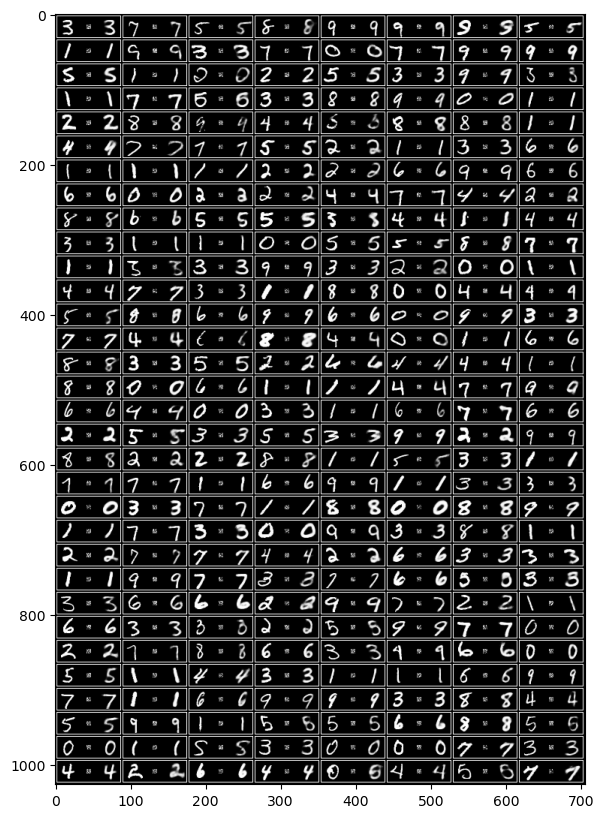

In [7]:
#get some test images and run them through the autoencoder
test_images, _ = next(iter(testloader)) #uses iter and next, which are standard Python functions. Iter creates an interable of testloader, and next returns the first batch

test_outputs = autoencoder(test_images.to(device).view(test_images.size(0), -1)) #take the images, put them on the correct device, resize the dimensions, and send to model

latent_space_images = autoencoder.encoder(test_images.to(device).view(test_images.size(0), -1)) #Let's look at the latent space images as well!
latent_space_images = latent_space_images.detach().reshape(-1, 1, 6, 6).to("cpu") #reshape to 6x6 tensors (images)
latent_space_images = F.pad(latent_space_images, (11, 11, 11, 11), 'constant', 0) #add 11 padding to add side so that 11 +_6 + 11 = 28


test_images = test_images.detach().reshape(-1, 1, 28, 28).to("cpu") #We will first detach the tensor, which essentially removes all the computational graph data, as we don't want the operations we are about to do to be tracked. Also it helps improve memory efficiency

test_outputs = test_outputs.detach().reshape(-1, 1, 28, 28).to("cpu") #Next, we reshape the tensor from (batch_size, 784) to (batch_size, 1, 28, 28). The "1" is important because the form (batch_size, channels, height, width) is expected by many PyTorch functions. Note that (test_images.size(0), 1, 28, 28) would have also been valid. Additionally, we also make sure this tensor is on the CPU so that we can visualize it

concat_grid = torch.cat([test_images, latent_space_images, test_outputs], 3) #Concatenates test_images and test_outputs into one tensor along dimension 3 (width, keeping in mind dimensions start at 0) so that they are side-by-side

padding = 1

concat_grid = F.pad(concat_grid, (padding, padding, padding, padding), 'constant', 1) #adds a padding (border) to each concatenated tensor (each rectangular combination image)

image_grid = torchvision.utils.make_grid(concat_grid) #Uses make_grid to form the concatenated tensor into a grid of the images, which is also a new tensor. This tensor only has three dimensions, as the batch_size dimension is no longer needed (we formed all the images from the batches into a grid)


image_grid = image_grid.permute(1,2,0).numpy() #permute dimensions to (height, width, channels) then convert to a numpy array. We permute the dimensions because matplotlib's imshow() expects them in that order, and convert to numpy array because imshow() needs that too

plt.figure(figsize=(10,10)) #create a new figure for the plot with size 10 by 10 inches
plt.imshow(image_grid) #represent the image grid as an image

Save and show the figure

In [8]:
#save the plot image

output_dir = './outputs/'
if not os.path.exists(output_dir): #if no file exists, create it
    os.makedirs(output_dir)

filename = "./outputs/MNIST-Autoencoder-input-output.png"

base_filename, file_extension = os.path.splitext(filename) #function to split filename into everything before the extension and the extension itself
file_number = 1
while os.path.exists(f"{base_filename}_{file_number}{file_extension}"):
    file_number +=1
filename = f"{base_filename}_{file_number}{file_extension}"
plt.savefig(filename)


plt.show() #show the plot

print("CODE FINISHED!")

<Figure size 640x480 with 0 Axes>

CODE FINISHED!
